In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

## Data Preparation

In [2]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define the local storage path for the 'animals' dataset
local_data_dir = 'C:/Users/nisha/Projects/Big Cats Species Prediction/animals'

# Define the target directories for the split dataset
train_dir = 'C:/Users/nisha/Projects/Big Cats Species Prediction//train'
validation_dir = 'C:/Users/nisha/Projects/Big Cats Species Prediction//validation'
test_dir = 'C:/Users/nisha/Projects/Big Cats Species Prediction/test'

# Create the target directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Split the dataset into train, validation, and test sets
for species in ['cheetah', 'leopard', 'lion', 'tiger']:
    species_dir = os.path.join(local_data_dir, species)
    
    # Create subdirectories in the target directories for each species
    os.makedirs(os.path.join(train_dir, species), exist_ok=True)
    os.makedirs(os.path.join(validation_dir, species), exist_ok=True)
    os.makedirs(os.path.join(test_dir, species), exist_ok=True)
    
    # Split the images for each species
    all_images = os.listdir(species_dir)
    train_images, test_images = train_test_split(all_images, test_size=0.2, random_state=100)
    validation_images, test_images = train_test_split(test_images, test_size=0.5, random_state=100)
    
    # Move images to the respective directories
    for image in train_images:
        src = os.path.join(species_dir, image)
        dst = os.path.join(train_dir, species, image)
        shutil.copy(src, dst)
    
    for image in validation_images:
        src = os.path.join(species_dir, image)
        dst = os.path.join(validation_dir, species, image)
        shutil.copy(src, dst)
    
    for image in test_images:
        src = os.path.join(species_dir, image)
        dst = os.path.join(test_dir, species, image)
        shutil.copy(src, dst)


## Data Pre-processing 

In [3]:
# Define data preprocessing and augmentation parameters
image_size = (224, 224)  # ResNet-50 input size
batch_size = 32

# Data Augmentation and Preprocessing for Training Data
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,        # Normalize pixel values to [0, 1]
    rotation_range=20,          # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,      # Randomly shift images horizontally
    height_shift_range=0.2,     # Randomly shift images vertically
    shear_range=0.2,            # Shear transformations
    zoom_range=0.2,             # Randomly zoom in on images
    horizontal_flip=True,       # Randomly flip images horizontally
    fill_mode='nearest'         # Fill in new pixels with the nearest available value
)

# Data Augmentation and Preprocessing for Validation and Test Data
validation_test_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0  # Normalize pixel values to [0, 1]
)

# Create data generators for training, validation, and test sets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_test_datagen.flow_from_directory(
    validation_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = validation_test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)


Found 585 images belonging to 4 classes.
Found 73 images belonging to 4 classes.
Found 71 images belonging to 4 classes.


### Model Building

In [4]:
# Create the base ResNet-50 model without the top (fully connected) layers
base_model = ResNet50(weights='imagenet', include_top=False)

# Add custom classification layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling layer
x = Dense(1024, activation='relu')(x)  # Fully connected layer
predictions = Dense(4, activation='softmax')(x)  # Output layer for 4 big cat species

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(lr=0.0001),  # You can adjust the learning rate as needed
              loss='categorical_crossentropy',
              metrics=['accuracy'])


### Model Training

In [6]:
from PIL import Image


In [7]:
# Define the number of training and validation steps per epoch
num_train_samples = train_generator.samples
num_validation_samples = validation_generator.samples

train_steps = num_train_samples // batch_size
validation_steps = num_validation_samples // batch_size

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    verbose=1
)


Epoch 1/20
18/18 [==============================] - 100s 5s/step - loss: 1.7584 - accuracy: 0.6184 - val_loss: 3208.8174 - val_accuracy: 0.2500
Epoch 2/20
18/18 [==============================] - 85s 5s/step - loss: 1.1202 - accuracy: 0.6492 - val_loss: 439.4141 - val_accuracy: 0.2812
Epoch 3/20
18/18 [==============================] - 86s 5s/step - loss: 0.7573 - accuracy: 0.7143 - val_loss: 150.2266 - val_accuracy: 0.2344
Epoch 4/20
18/18 [==============================] - 90s 5s/step - loss: 0.5589 - accuracy: 0.7708 - val_loss: 15.6058 - val_accuracy: 0.2656
Epoch 5/20
18/18 [==============================] - 88s 5s/step - loss: 0.3756 - accuracy: 0.8535 - val_loss: 3.1626 - val_accuracy: 0.2344
Epoch 6/20
18/18 [==============================] - 87s 5s/step - loss: 0.3545 - accuracy: 0.8644 - val_loss: 2.0837 - val_accuracy: 0.2500
Epoch 7/20
18/18 [==============================] - 87s 5s/step - loss: 0.3132 - accuracy: 0.8825 - val_loss: 1.5151 - val_accuracy: 0.2812
Epoch 8/20


### Model Evaluation

In [8]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


3/3 [==============================] - 4s 945ms/step - loss: 3.2912 - accuracy: 0.2394
Test Loss: 3.2912
Test Accuracy: 23.94%


In [9]:
# Save the trained model
model.save('model1.keras')

## Model Prediction

In [10]:
from tensorflow.keras.models import load_model

# Load the trained model
model1 = load_model('model1.keras')

In [11]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load the image you want to predict
image_path = 'C:/Users/nisha/OneDrive/Pictures/lion.jpg'
img = load_img(image_path, target_size=(224, 224))  # Resize to match model input size
img = img_to_array(img)
img = img / 255.0  # Normalize pixel values to [0, 1]
img = np.expand_dims(img, axis=0)  # Add a batch dimension


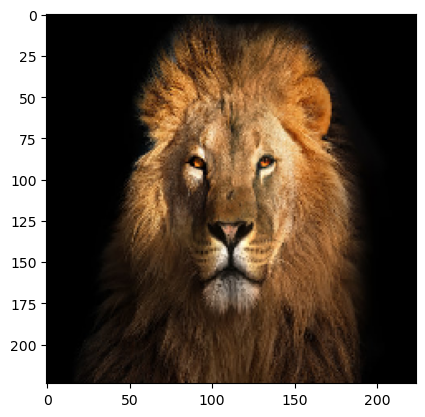

In [12]:
# Display the imported image
import matplotlib.pyplot as plt
plt.imshow(img[0])
plt.show()

In [13]:
# Make a prediction
predictions = model1.predict(img)

# Get the class label with the highest probability
predicted_class_index = np.argmax(predictions)


1/1 [==============================] - 1s 1s/step


In [14]:
class_names = ['Cheetah', 'Leopard', 'Lion', 'Tiger']
predicted_class = class_names[predicted_class_index]

print(f"The predicted big cat species is: {predicted_class}")


The predicted big cat species is: Lion
